<a href="https://colab.research.google.com/github/mark-one-anry/ds01/blob/main/mouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Mouse Gensture Recoginition
## Imports Section
import tensorflow as tf
import numpy as np 
from tensorflow import keras
from tensorflow import lite
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Activation, Flatten, Conv2D, MaxPooling2D 
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import lite

In [ ]:
## Constants section
IMAGE_WIDTH = 75
IMAGE_HEIGHT = 55
DATAFILE = "genstures.json"
TESTFILE = "test_gensture.json"

Для распознавания жестов мыши будет использована свёрточная нейросеть по образу MNIST. На вход в сеть подаётся изображение размером 60х60 в виде вектора из 75*55 = 4'125 элементов. Элемент содержит либо 0 либо 1 (нет пикселя, есть пиксель)

# Параметры сети
**Первый скрытый слой**

*   размер скользящего окна (kernel size): 5
*   количество фильтров: 8
*   шаг скользящего окна (strides): 1
*   Функция активации: relu
*   Инициализация ядра: variaceScaling

**Max pooling слой (снижение размерности, отвязка от местоположения фич)**
*   poolSize: 2x2
*   strides: 2x2

**Второй скрытый слой**

*   размер скользящего окна (kernel size): 5
*   количество фильтров: 16
*   шаг скользящего окна (strides): 1
*   Функция активации: relu
*   Инициализация ядра: variaceScaling

**Max pooling слой (снижение размерности)**
*   poolSize: 2x2
*   strides: 2x2

**Слой flatten**

**Выходной слой классификатор**
*   Инициализация ядра: variaceScaling
*   Функция активации: softmax 

** Параметры обучения **
*   Функция потерь: categoricalCrosentropy
*   mertric: accuracy





In [ ]:
tf.__version__

'2.7.0'

In [ ]:
## Подключение Google диска: выполнить отдельно и вставить код
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# читаем всегда этот файл 
with open('/content/drive/My Drive/GColab/' + DATAFILE, 'r') as f:
  content = f.read()
# вычищаем всё, кроме цифр
content = re.sub('\D', '', content)
# преобразуем в List
data = []
for c in content:
    data.append(int(c))
# Преобразовать int в Numpy (т.к. их принимает модель Keras)
data = np.array(data)
# Переводим в 3D массив
numOfImages = int(len(data) / (IMAGE_HEIGHT * IMAGE_WIDTH))
data = np.array(data).reshape(numOfImages, IMAGE_HEIGHT,IMAGE_WIDTH)

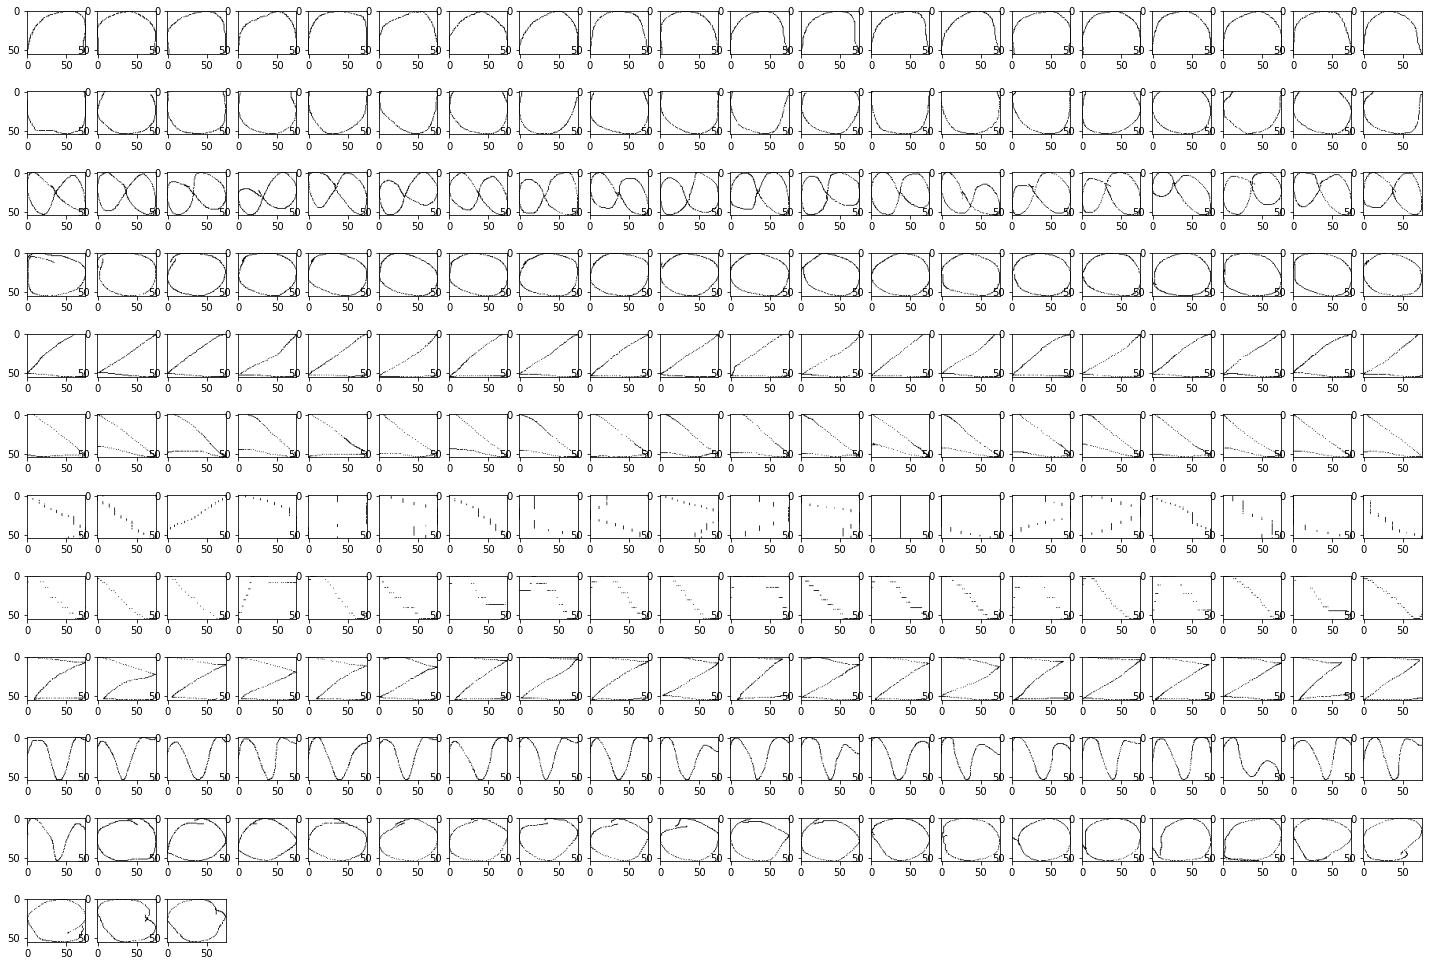

In [ ]:
# Посмотрим, что загрузили
# plt.imshow(data[0], cmap='gray', vmin=0, vmax=1)
# plt.show()
w=10
h=10
fig=plt.figure(figsize=(25, 25))
columns = 20
rows = 17
numOfImagesToDisplay = columns*rows +1;
if numOfImagesToDisplay > (len(data) + 1):
    numOfImagesToDisplay = len(data) + 1
for i in range(1, numOfImagesToDisplay):
    fig.add_subplot(rows, columns, i)
    plt.imshow(data[i-1], cmap = plt.cm.binary)
plt.show()

In [ ]:
# Разметка данных по классам (ДЕЛАЕМ РУКАМИ)
# 1 - подкова (пересечение)
# 2 - подкова (объединение)
# 3 - восьмёрка
# 4 - круг
# 5 - угол влево
# 6 - угол вправо
# 7 - вертикальная линия
# 8 - горизонтальная линия
# 9 - Z
# 0 - волна
y = [
     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
     3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
     4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
     5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
     6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
     7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
     8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
     9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
     4, 4, 4
]
y = np.array(y)

In [ ]:
# Разбить данные на обучающие и проверочные
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

num_classes = len(set(y))

# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Модель-пример для MNIST https://keras.io/examples/vision/mnist_convnet/
# Часть параметров изменены по предыдущей JS модели
model = keras.Sequential(
    [
        keras.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 1]),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", kernel_initializer="variance_scaling"),
        layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu", kernel_initializer="variance_scaling"),
        layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(len(set(y)), activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 51, 71, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 35, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 31, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 15, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 9600)              0         
                                                                 
 dropout_1 (Dropout)         (None, 9600)             

In [ ]:
# Обучение модели
batch_size = 128
epochs = 25

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/25
2/2 [==============================] - 1s 336ms/step - loss: 2.2455 - accuracy: 0.1813 - val_loss: 1.6198 - val_accuracy: 0.4444
Epoch 2/25
2/2 [==============================] - 1s 222ms/step - loss: 1.3853 - accuracy: 0.5250 - val_loss: 1.1563 - val_accuracy: 0.4444
Epoch 3/25
2/2 [==============================] - 1s 229ms/step - loss: 0.8713 - accuracy: 0.6313 - val_loss: 0.7479 - val_accuracy: 0.7222
Epoch 4/25
2/2 [==============================] - 1s 221ms/step - loss: 0.5449 - accuracy: 0.7937 - val_loss: 0.5139 - val_accuracy: 0.8889
Epoch 5/25
2/2 [==============================] - 1s 219ms/step - loss: 0.3705 - accuracy: 0.8813 - val_loss: 0.4744 - val_accuracy: 0.8889
Epoch 6/25
2/2 [==============================] - 1s 217ms/step - loss: 0.3786 - accuracy: 0.8500 - val_loss: 0.4729 - val_accuracy: 0.8333
Epoch 7/25
2/2 [==============================] - 1s 216ms/step - loss: 0.2496 - accuracy: 0.9250 - val_loss: 0.5242 - val_accuracy: 0.8889
Epoch 8/25
2/2 [====

In [ ]:
## Evaluate the trained model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.45874643325805664
Test accuracy: 0.9111111164093018


In [ ]:
# Sample Call
smpl = data[11].reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH,1);
smpl_res = model.predict(smpl)
smpl_res

array([[4.8857451e-13, 9.9970055e-01, 3.0984449e-13, 2.8493671e-10,
        2.9945100e-04, 2.4146570e-19, 1.9377078e-13, 7.8963431e-09,
        6.5046711e-11, 1.3609990e-13]], dtype=float32)

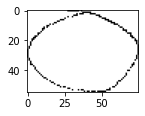

In [ ]:
# Проверка примера распознавания
with open('/content/drive/My Drive/GColab/' + TESTFILE, 'r') as f:
  content = f.read()
# вычищаем всё, кроме цифр
content = re.sub('\D', '', content)
# преобразуем в List
testdata = []
for c in content:
    testdata.append(int(c))
# Преобразовать int в Numpy (т.к. их принимает модель Keras)
testdata = np.array(testdata)
# Переводим в 3D массив
numOfImages = int(len(testdata) / (IMAGE_HEIGHT * IMAGE_WIDTH))
testdata = np.array(testdata).reshape(numOfImages, IMAGE_HEIGHT,IMAGE_WIDTH)

w=2
h=2
fig=plt.figure(figsize=(2, 2))
columns = 2
rows = 2
plt.imshow(testdata[0], cmap = plt.cm.binary)
plt.show()

In [ ]:
## Распознать пример
checkme = testdata.reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH,1);
results = model.predict(checkme)
print(results)
arr = results.tolist()
#print("Your image got class " + str(arr.index(max(arr))) + " with probability " + str(max(arr)))
print(results.argmax())

[[1.1562278e-13 2.7496382e-05 2.6077487e-12 3.8121806e-10 9.9997246e-01
  3.4472506e-18 8.4368141e-13 2.0085620e-08 5.2756346e-14 9.2486400e-12]]
4


In [ ]:
# Сохранить модель на Google Drive
keras_file = "/content/drive/My Drive/GColab/genstureRecognizer.h5"
keras.models.save_model(model, keras_file)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
litemodel = converter.convert()
open("/content/drive/My Drive/GColab/genstureRecognizer.tflite", "wb").write(litemodel)

INFO:tensorflow:Assets written to: /tmp/tmpbaw9r7sm/assets


595116

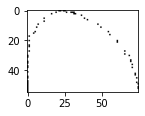

Class  7  with probability  0.86470634


In [ ]:
# Свободное тестирование. Загрузите из логов последовательность 0 и 1 для распознавания и рисования
recognizeMe = "000000000000000000000110110000000000000000000000000000000000000000000000000000000000000000000010000001001110000000000000000000000000000000000000000000000000000000000010000000000000011000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000100000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000100000000000000000000000000000000000000000000000000000000000000000001000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000100000000000000000000000000000000000000000000000000000000000000000000100000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000100000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000100100000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000010100000000000000000000000000000000000000000000000000000000000000000000000001100000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000001100000000000000000000000000000000000000000000000000000000000000000000000001100000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000";
# преобразуем в List
testdata = []
for c in recognizeMe:
    testdata.append(int(c))
# Преобразовать int в Numpy (т.к. их принимает модель Keras)
testdata = np.array(testdata)
# Переводим в 3D массив
numOfImages = int(len(testdata) / (IMAGE_HEIGHT * IMAGE_WIDTH))
testdata = np.array(testdata).reshape(numOfImages, IMAGE_HEIGHT,IMAGE_WIDTH)

w=2
h=2
fig=plt.figure(figsize=(2, 2))
columns = 2
rows = 2
plt.imshow(testdata[0], cmap = plt.cm.binary)
plt.show()

checkme = testdata.reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH,1);
results = model.predict(checkme)
# print(results)
arr = results.tolist()
print("Class ", results.argmax(), " with probability ", results[0][results.argmax()]);